In [30]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import os 
import sys 
import pickle
root_path = os.path.realpath('../')
sys.path.append(root_path)

from utils.parser import parse_alldata
from utils.analysis import print_testacc, print_ttest_acc, compute_choicemats, fit_sigmoids_to_choices, gen_choicemodelrdms, stats_fit_choicerdms,fit_model_to_subjects
from utils.plotting import disp_accuracy, disp_lcurves, disp_sigmoid_fits, disp_param_estimates, disp_choicemats, disp_rsa_param_estimates, disp_model_estimates


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters

In [31]:
# set a few parameters 
working_dir = os.getcwd()
data_dir = working_dir + "/../data/animals_vehicles_1_base/"

domains = ['animals','vehicles']
curricula = ['blocked','interleaved']


# Data Import

In [32]:
# parse data 
try:
    with open(data_dir+"parsed/"+"animals_vehicles_pilot.pkl","rb") as f:
        alldata = pickle.load(f)
except FileNotFoundError:
    alldata = parse_alldata(data_dir+"raw/")
    from utils.parser import boundary_to_nan
    alldata = boundary_to_nan(alldata)
    with open(data_dir+"parsed/"+"animals_vehicles_pilot.pkl","wb") as f:
        pickle.dump(alldata,f)
    


# Analysis

## Accuracy

### calculate accuracy and test for between group differences

In [33]:

print_testacc(alldata)
print('\n')
# does acc differ between groups?
print_ttest_acc(alldata)
print('\n\n')
print_testacc(alldata,onlygood=True)
print('\n')
print_ttest_acc(alldata,onlygood=True)       


** Accuracy on base task **
all subjects (n=100): animals, blocked: 0.75
all subjects (n=100): animals, interleaved: 0.74
all subjects (n=100): vehicles, blocked: 0.80
all subjects (n=100): vehicles, interleaved: 0.82


** T-tests on base task **
all subjects: animals, blocked vs interleaved: p= 0.692
all subjects: vehicles, blocked vs interleaved: p= 0.445



** Accuracy on base task **
only good subjects (n=94): animals, blocked: 0.78
only good subjects (n=99): animals, interleaved: 0.75
only good subjects (n=96): vehicles, blocked: 0.82
only good subjects (n=99): vehicles, interleaved: 0.82


** T-tests on base task **
only good subjects: animals, blocked vs interleaved: p= 0.111
only good subjects: vehicles, blocked vs interleaved: p= 0.997


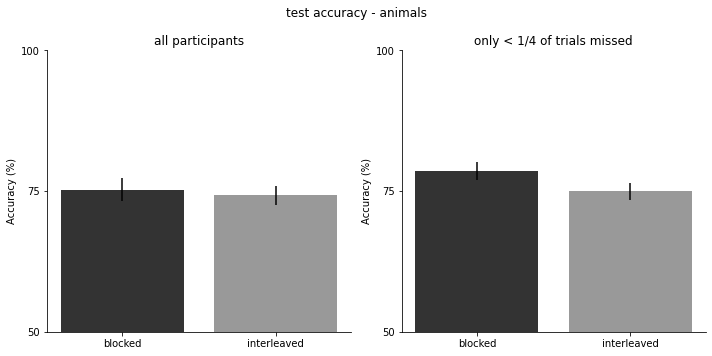

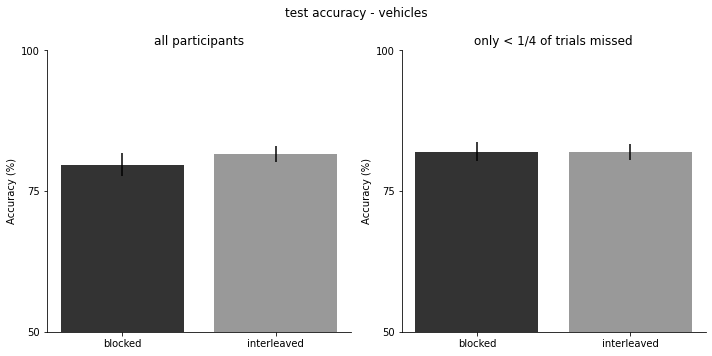

In [34]:
# plot test accuracy
disp_accuracy(alldata,'animals')
disp_accuracy(alldata,'vehicles')
        


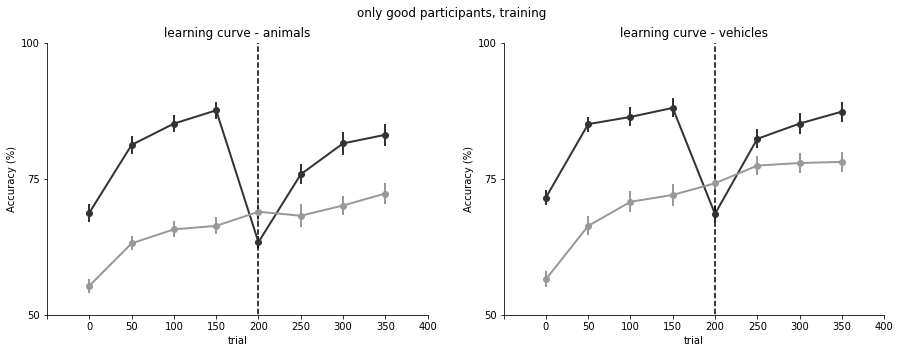

In [35]:
# learning curves
disp_lcurves(alldata)

## Choice Patterns

In [36]:
choicemats = compute_choicemats(alldata)

### display sigmoids for rel and irrel dimensions 

In [ ]:
betas = fit_sigmoids_to_choices(choicemats,onlygood=True)
disp_sigmoid_fits(choicemats,betas, onlygood=True)

In [ ]:
# stats on estimated slopes
disp_param_estimates(betas,onlygood=True)

### display full choice matrices

In [ ]:
disp_choicemats(choicemats,onlygood=True)

## Choice Pattern RSA


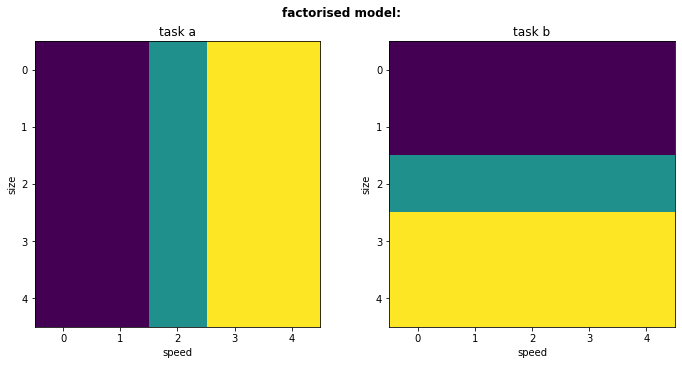

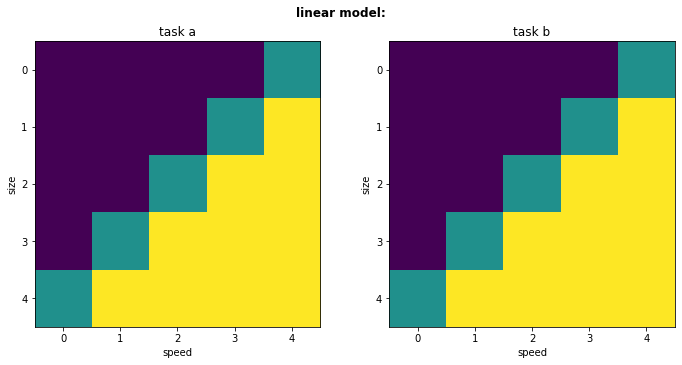

In [38]:
_ = gen_choicemodelrdms(monitor=True)

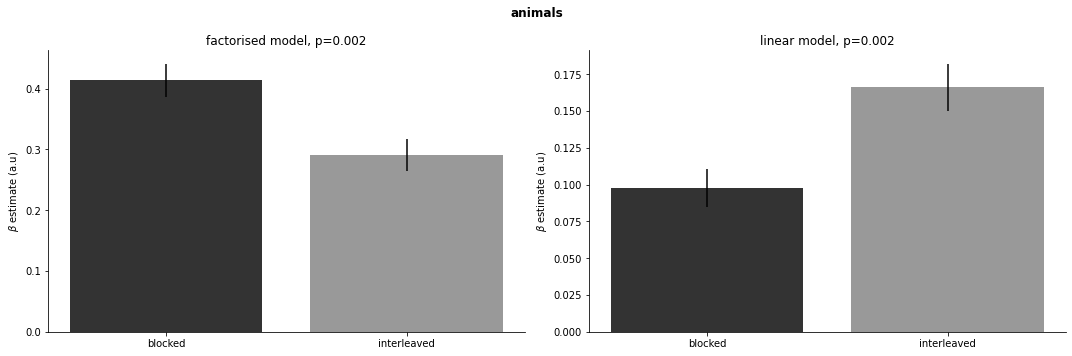

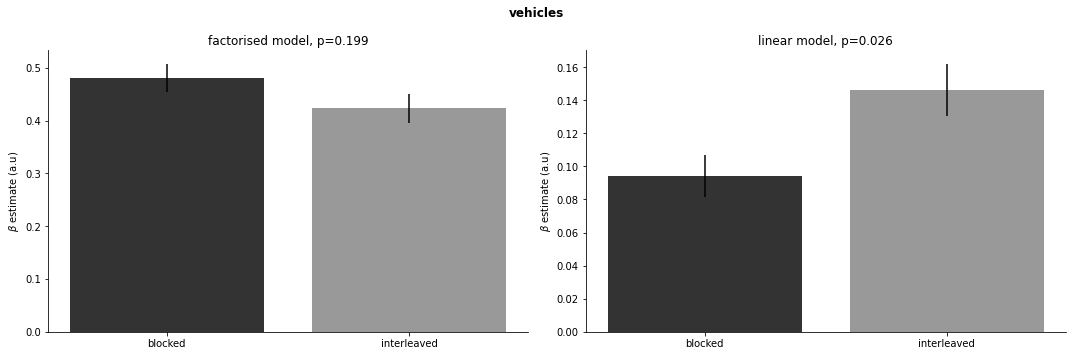

In [39]:
betas = stats_fit_choicerdms(choicemats,onlygood=True)
disp_rsa_param_estimates(betas,onlygood=True)

## Choice Model


In [40]:
thetas = fit_model_to_subjects(choicemats,onlygood=True)

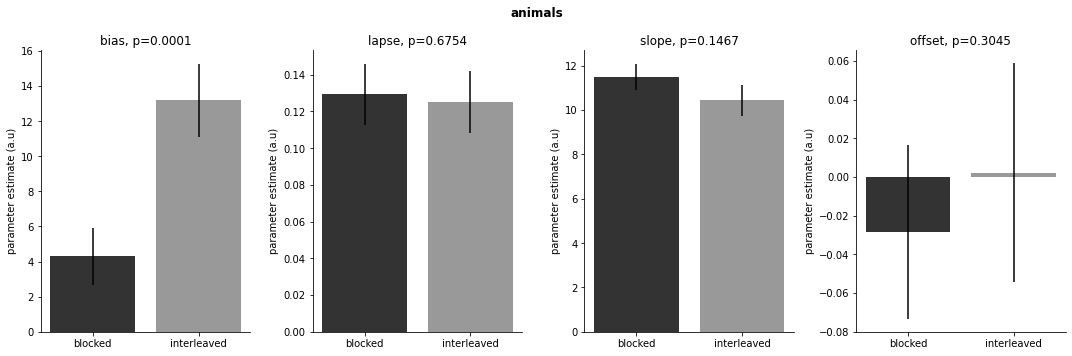

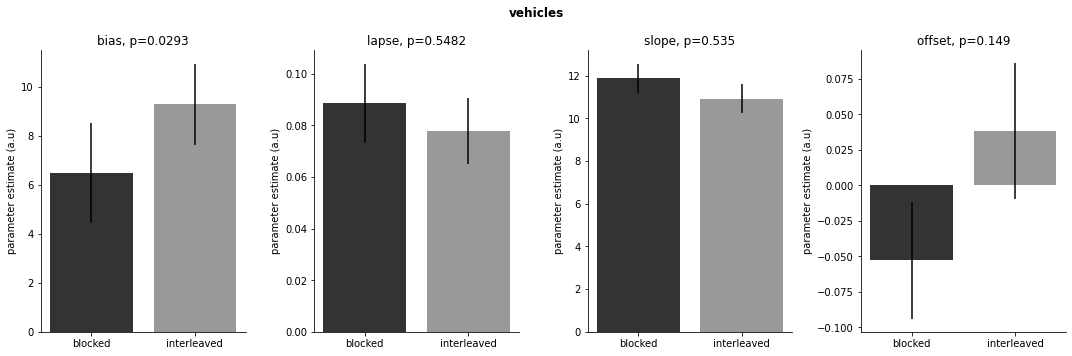

In [41]:
# stats on estimated slopes
disp_model_estimates(thetas)